<a href="https://colab.research.google.com/github/RV05/detectron2_flash-detection/blob/main/Detectron2_Tutorial_good_flash_maskedrcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/flash

/content/drive/MyDrive/flash


In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 26.7MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=79e4508516b3b63a4c5d8757421265224a2aea897834afe88371b9217ce7eeac
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.8.1+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.2MB 593kB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any.whl size=58543 sha256=07671db3402c86232eca5cc7e23ca46605b74263e77318fa0d3b48aa6f829752
  Stored in directory: /root/.cache/pip/wheels/d2/ee/3a/5c531df777c03d8c67f22c65f97d6f75321087482d05a9b218
Successfully built fvcore


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train6", {}, "/content/drive/MyDrive/flash/train/train.json", "/content/drive/MyDrive/flash/train")
register_coco_instances("my_dataset_val6", {}, "/content/drive/MyDrive/flash/val/val.json", "/content/drive/MyDrive/flash/val")

# from detectron2.structures import BoxMode

# def get_balloon_dicts(img_dir):
#     json_file = os.path.join(img_dir, "via_region_data.json")
#     with open(json_file) as f:
#         imgs_anns = json.load(f)

#     dataset_dicts = []
#     for idx, v in enumerate(imgs_anns.values()):
#         record = {}
        
#         filename = os.path.join(img_dir, v["filename"])
#         height, width = cv2.imread(filename).shape[:2]
        
#         record["file_name"] = filename
#         record["image_id"] = idx
#         record["height"] = height
#         record["width"] = width
      
#         annos = v["regions"]
#         objs = []
#         for _, anno in annos.names():
#             assert not anno["region_attributes"]
#             anno = anno["shape_attributes"]
#             px = anno["all_points_x"]
#             py = anno["all_points_y"]
#             poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
#             poly = [p for x in poly for p in x]

#             obj = {
#                 "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
#                 "bbox_mode": BoxMode.XYXY_ABS,
#                 "segmentation": [poly],
#                 "category_id": 0,
#             }
#             objs.append(obj)
#         record["annotations"] = objs
#         dataset_dicts.append(record)
#     return dataset_dicts

# for d in ["train", "val"]:
#     DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
#     MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
# balloon_metadata = MetadataCatalog.get("balloon_train")

WARNING [05/14 15:15:53 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/14 15:15:53 d2.data.datasets.coco]: Loaded 43 images in COCO format from /content/drive/MyDrive/flash/train/train.json


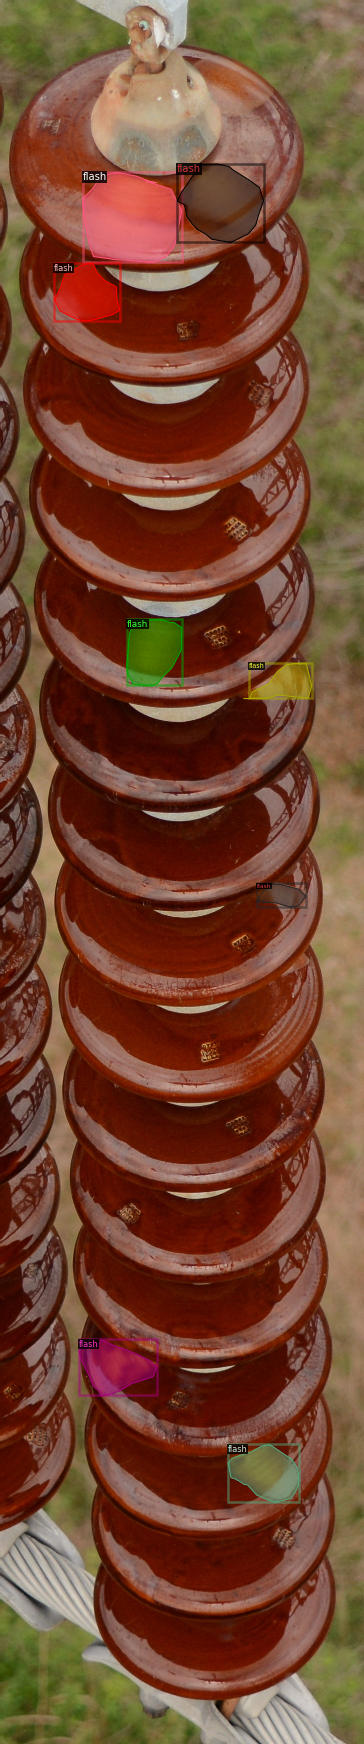

In [ ]:
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train6")
dataset_dicts = DatasetCatalog.get("my_dataset_train6")
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU, or ~2 minutes on a P100 GPU.


In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train6",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 2000   # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[05/14 08:48:42 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:20, 8.70MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to i

[05/14 08:49:05 d2.engine.train_loop]: Starting training from iteration 0
[05/14 08:49:31 d2.utils.events]:  eta: 0:41:31  iter: 19  total_loss: 2.345  loss_cls: 0.9392  loss_box_reg: 0.3163  loss_mask: 0.6895  loss_rpn_cls: 0.2929  loss_rpn_loc: 0.02496  time: 1.2171  data_time: 0.0968  lr: 4.9953e-06  max_mem: 2675M
[05/14 08:49:57 d2.utils.events]:  eta: 0:42:11  iter: 39  total_loss: 2.056  loss_cls: 0.8075  loss_box_reg: 0.289  loss_mask: 0.6831  loss_rpn_cls: 0.3197  loss_rpn_loc: 0.01982  time: 1.2589  data_time: 0.0111  lr: 9.9902e-06  max_mem: 2763M
[05/14 08:50:22 d2.utils.events]:  eta: 0:41:46  iter: 59  total_loss: 2.025  loss_cls: 0.6383  loss_box_reg: 0.47  loss_mask: 0.6696  loss_rpn_cls: 0.2684  loss_rpn_loc: 0.02892  time: 1.2578  data_time: 0.0092  lr: 1.4985e-05  max_mem: 2763M
[05/14 08:50:47 d2.utils.events]:  eta: 0:41:16  iter: 79  total_loss: 1.73  loss_cls: 0.5038  loss_box_reg: 0.4129  loss_mask: 0.6516  loss_rpn_cls: 0.1607  loss_rpn_loc: 0.01834  time: 1.24

In [ ]:
while 1:pass

KeyboardInterrupt: ignored

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train6",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 2000   # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

WARNING [05/14 15:21:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/14 15:21:31 d2.data.datasets.coco]: Loaded 6 images in COCO format from /content/drive/MyDrive/flash/val/val.json


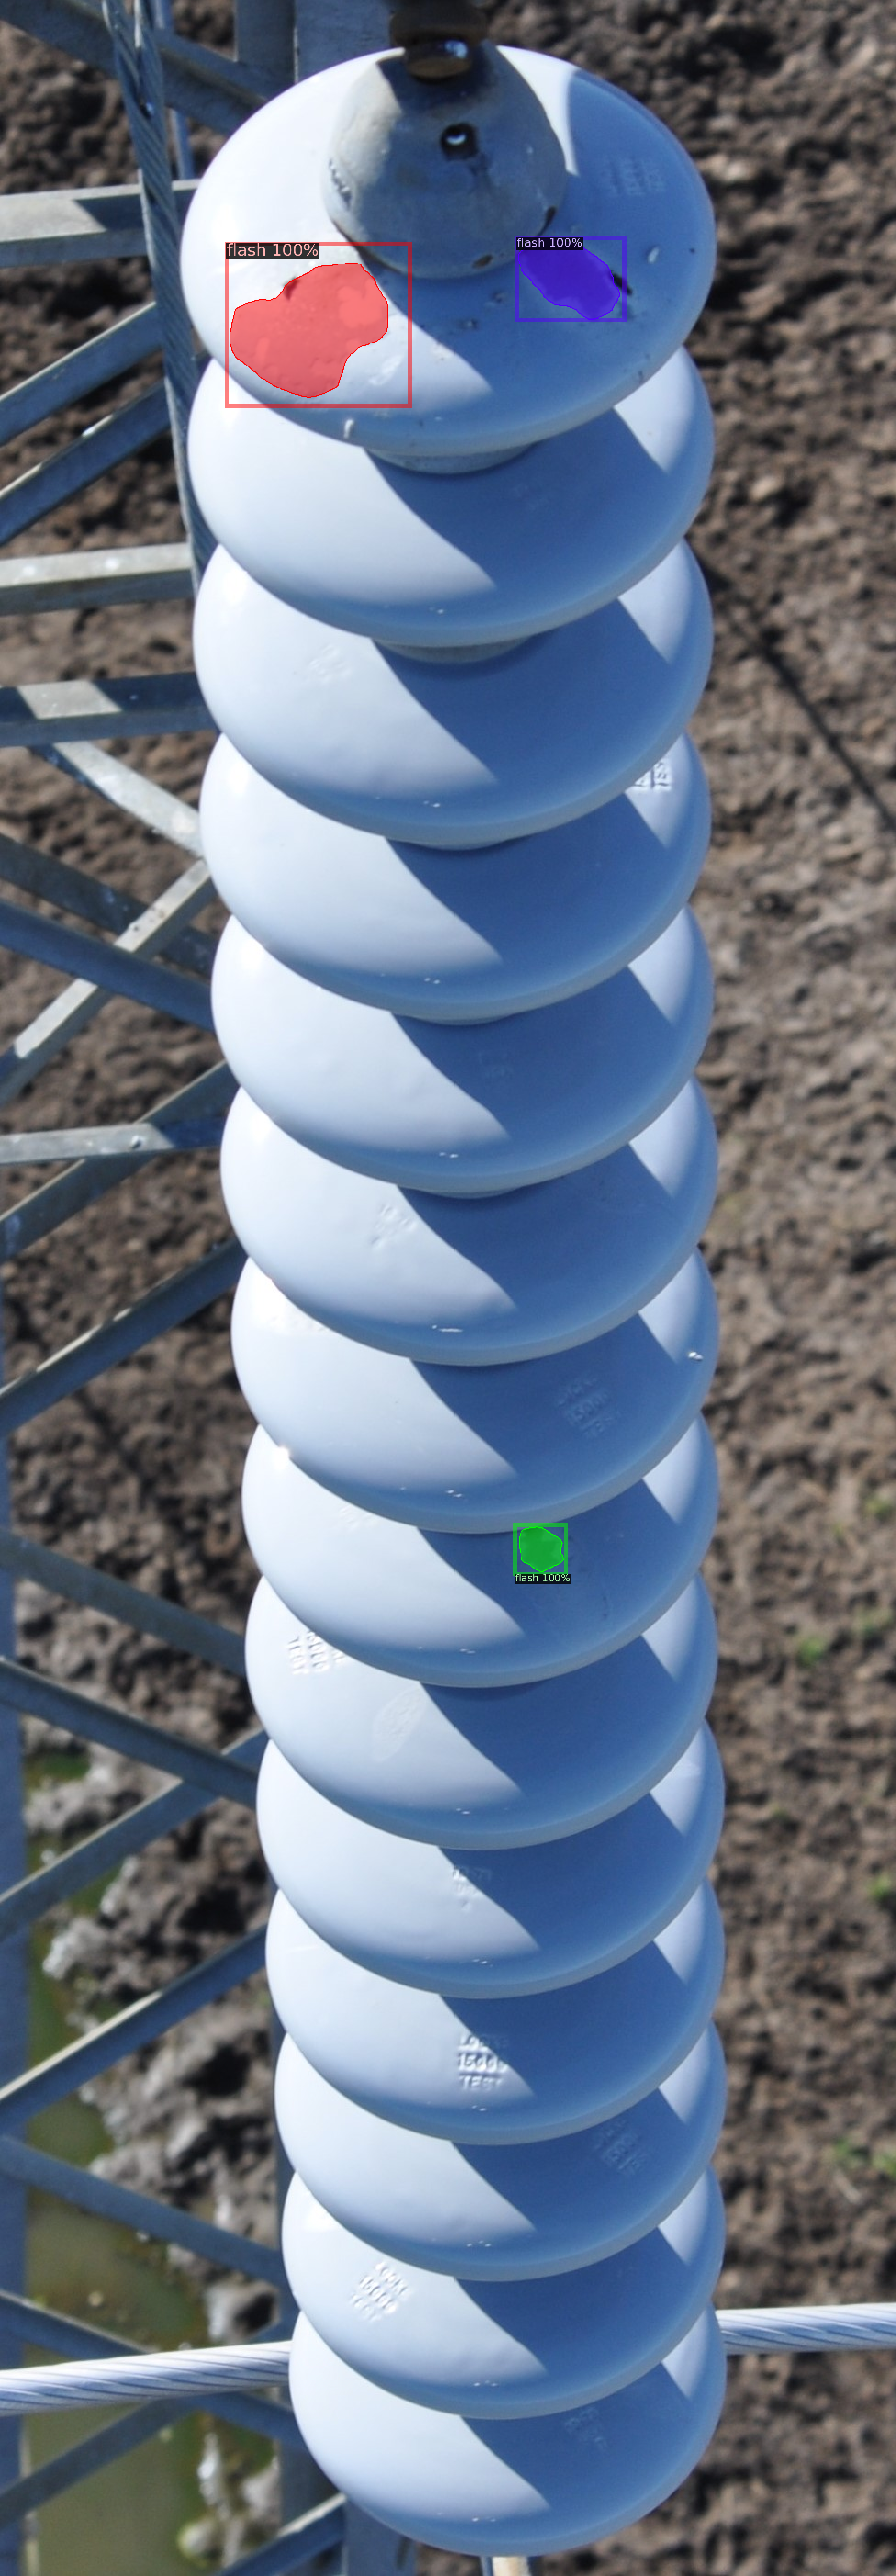

In [ ]:
from detectron2.utils.visualizer import ColorMode
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_val6")
dataset_dicts = DatasetCatalog.get("my_dataset_val6")

im = cv2.imread("/content/drive/MyDrive/flash/train/130126.jpg")
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1],
                metadata=my_dataset_train_metadata, 
                scale=2, 
                  # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
b=outputs["instances"].pred_masks
cv2_imshow(out.get_image()[:, :, ::-1])


In [ ]:
while 1:pass

KeyboardInterrupt: ignored

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_train2", ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val2")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[05/13 15:45:49 d2.data.datasets.coco]: Loaded 49 images in COCO format from /content/drive/MyDrive/balloon/val/val.json
[05/13 15:45:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/13 15:45:49 d2.data.common]: Serializing 49 elements to byte tensors and concatenating them all ...
[05/13 15:45:49 d2.data.common]: Serialized dataset takes 0.35 MiB
[05/13 15:45:49 d2.evaluation.evaluator]: Start inference on 49 images
[05/13 15:45:55 d2.evaluation.evaluator]: Inference done 11/49. 0.3570 s / img. ETA=0:00:15
[05/13 15:46:00 d2.evaluation.evaluator]: Inference done 24/49. 0.3552 s / img. ETA=0:00:09
[05/13 15:46:05 d2.evaluation.evaluator]: Inference done 38/49. 0.3552 s / img. ETA=0:00:04
[05/13 15:46:09 d2.evaluation.evaluator]: Total inference time: 0:00:17.087521 (0.388353 s / img per device, on 1 devices)
[05/13 15:46:09 d2.evaluation.evaluator]: Total inference p

In [ ]:
cd /content

/content


0


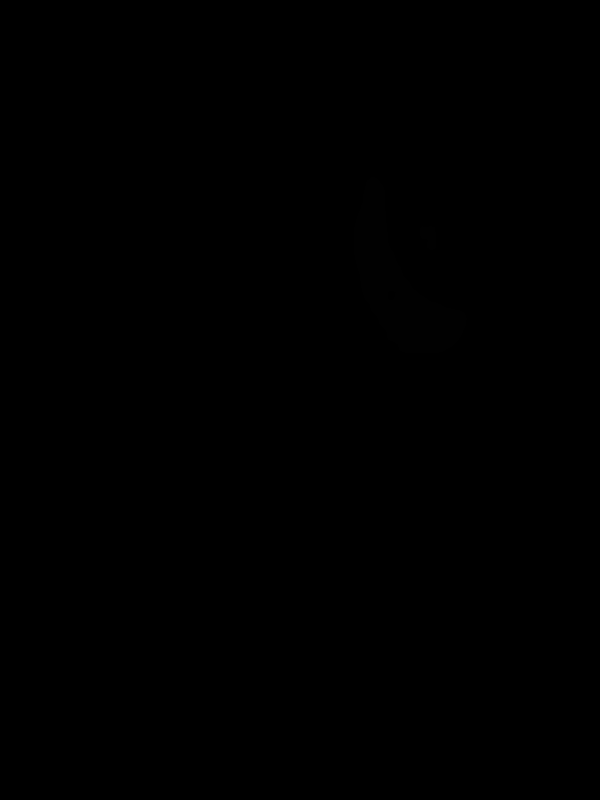

1


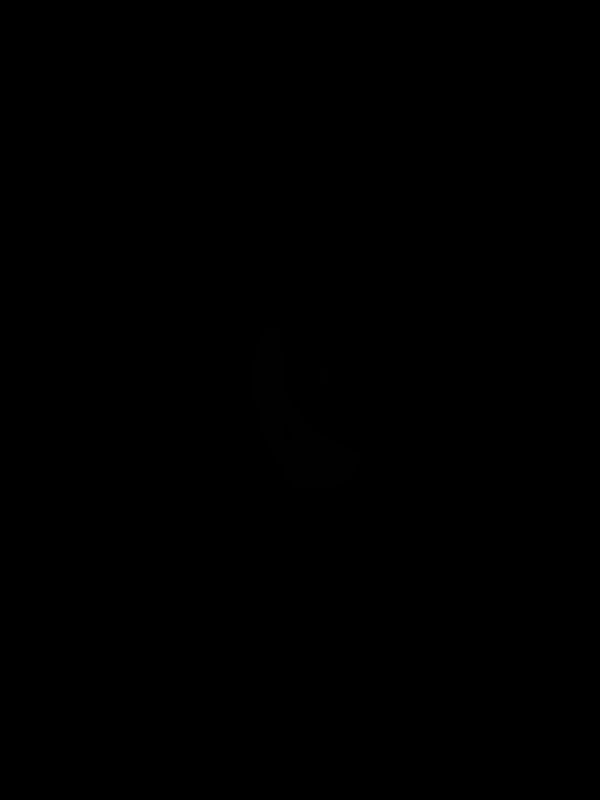

2


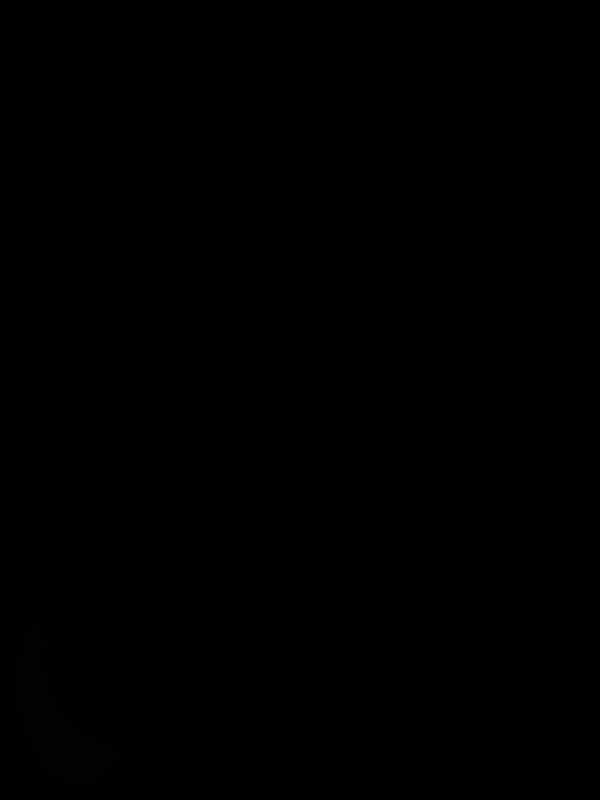

3


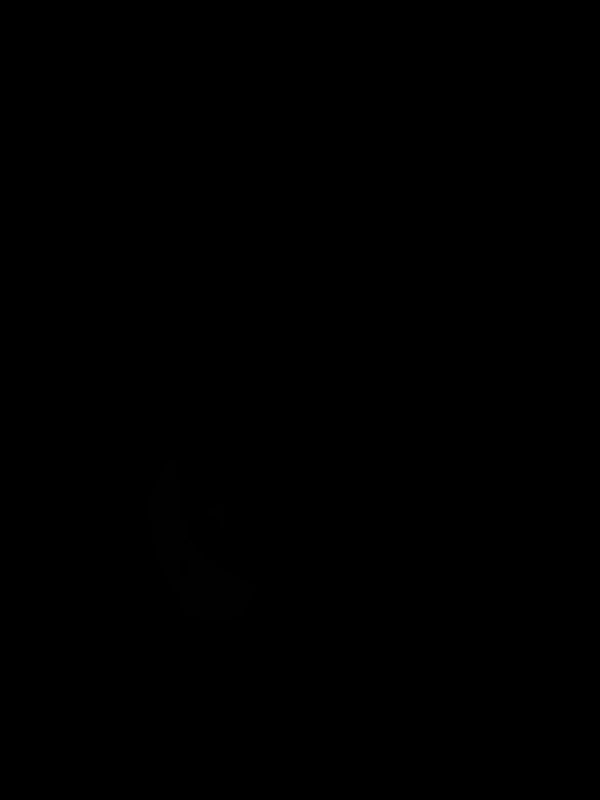

4


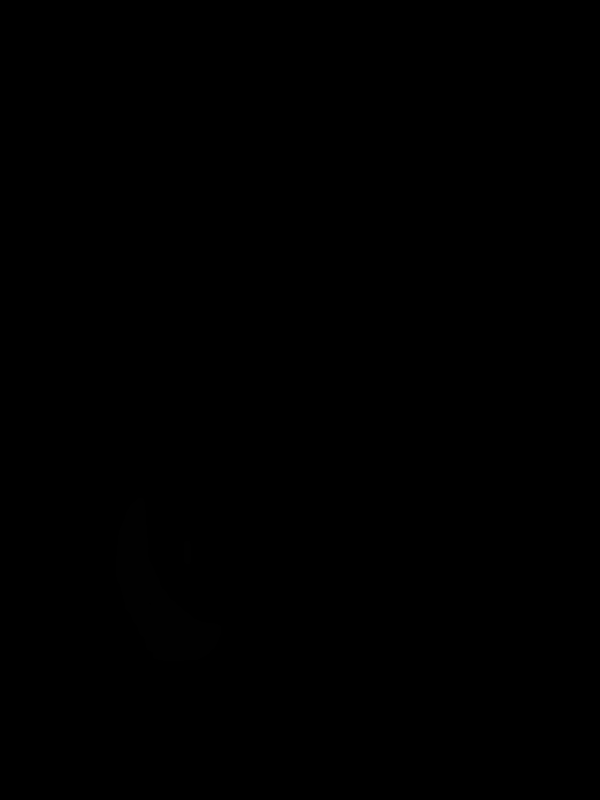

5


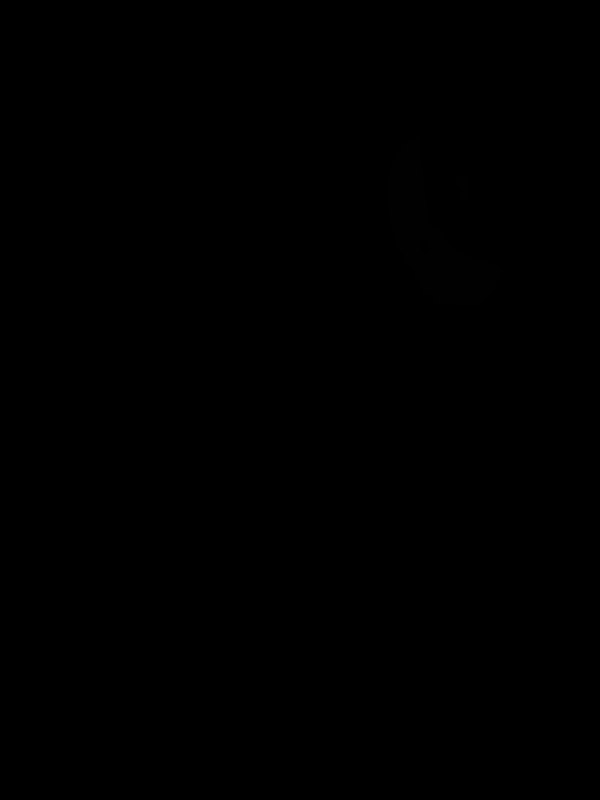

6


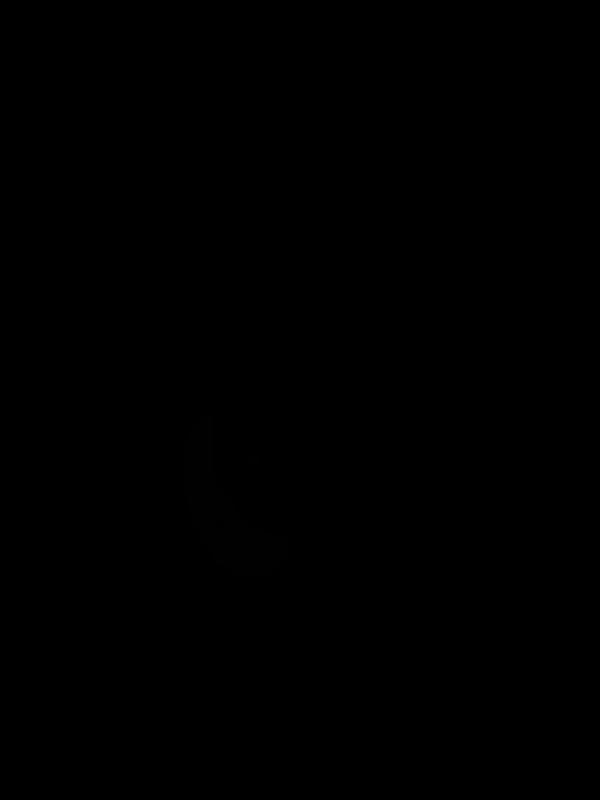

7


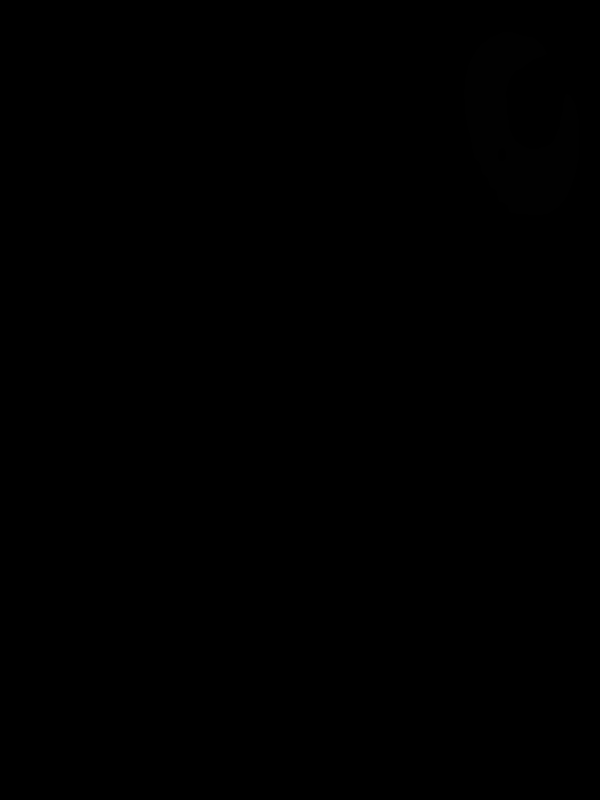

8


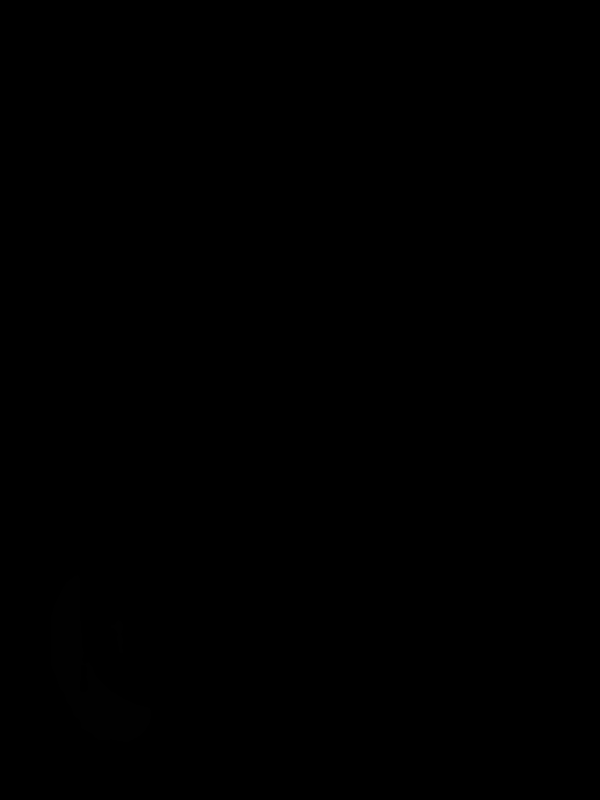

9


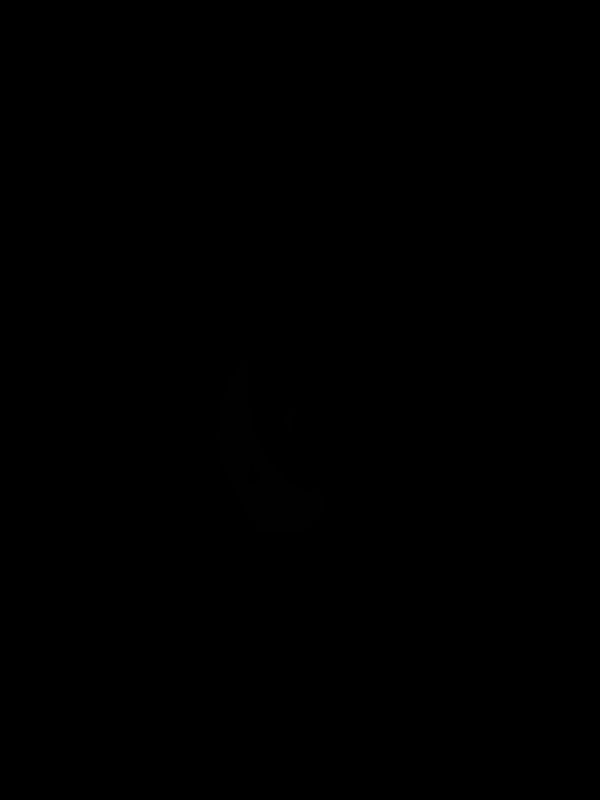

10


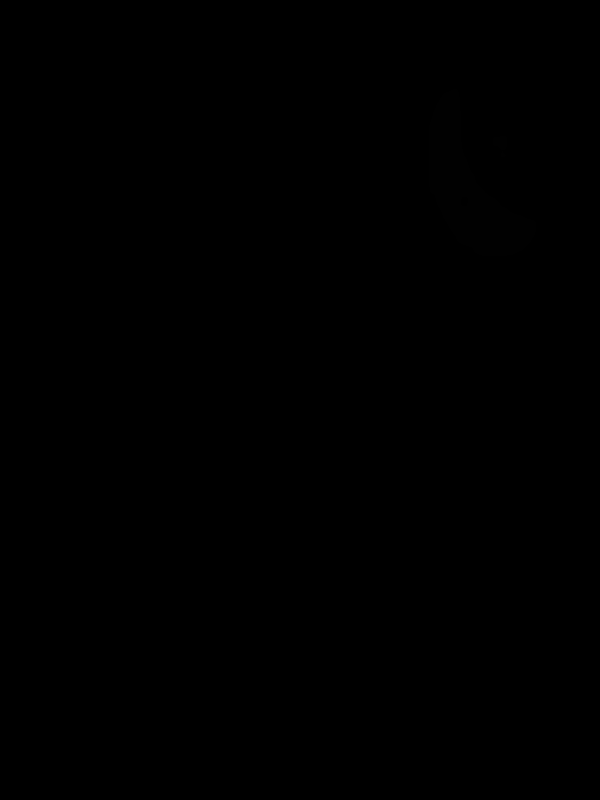

11


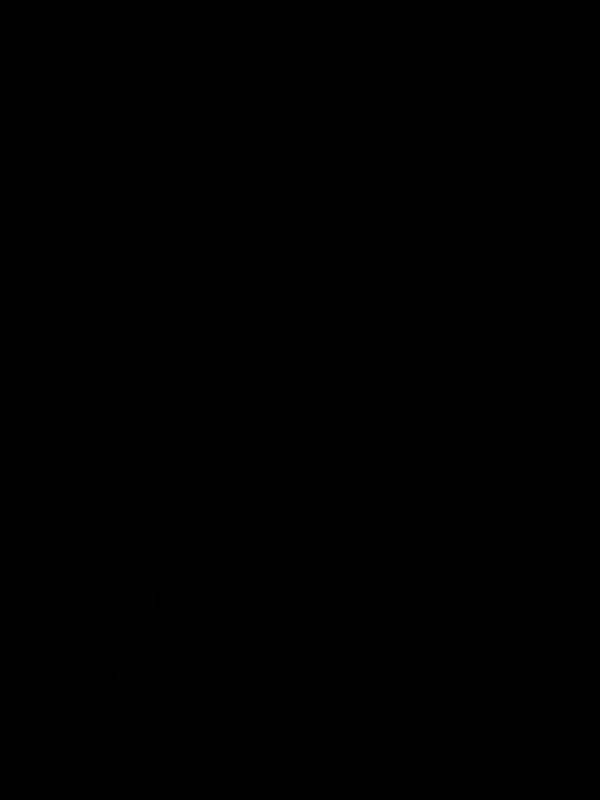

12


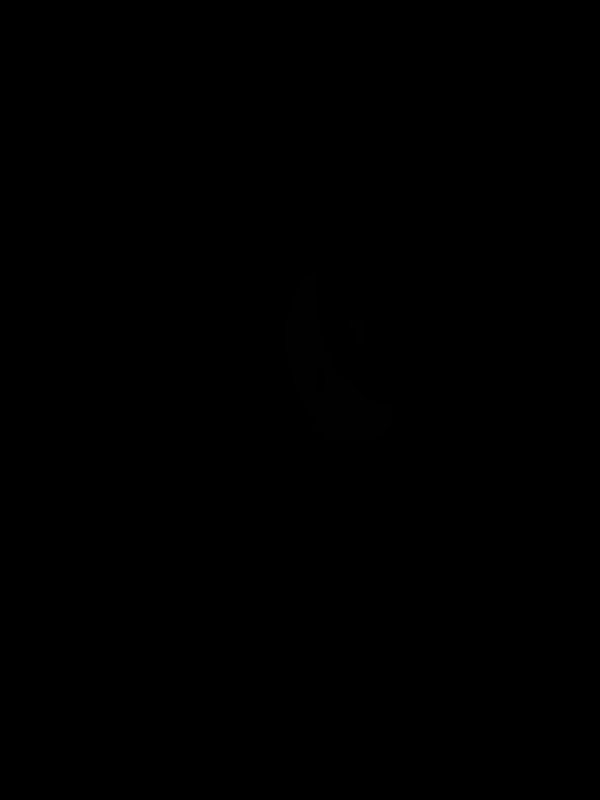

13


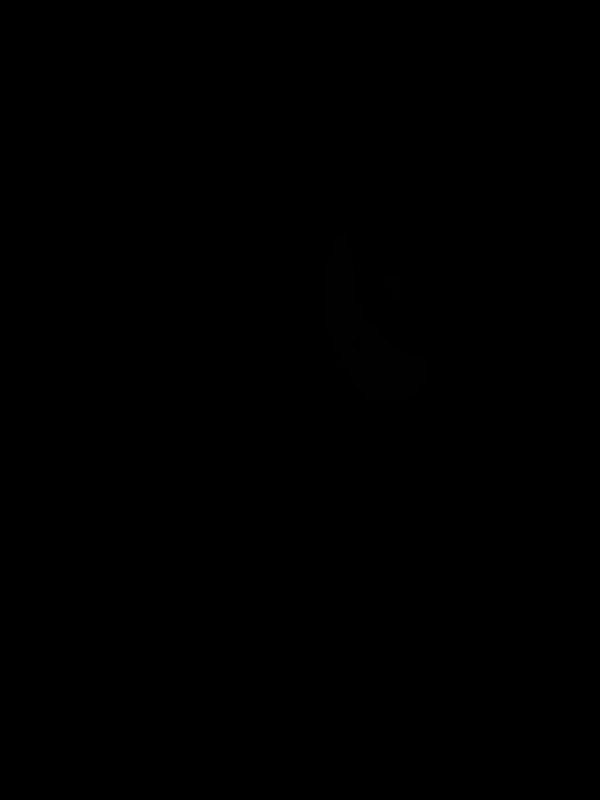

14


IndexError: ignored

In [ ]:
import matplotlib.pyplot as plt
for i in range(15):
  print(i)
  cv2_imshow(b.cpu().numpy()[i])
  

In [ ]:
while 1:pass

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
for i in range(4):
  print(i)
  cv2_imshow(b.cpu().numpy()[i])
  